##### MAINTENANCE TECHNICAL DATA ANALYSIS

With this analysis I'd like to answer the following questions:

 - What is the main characteristics of the dataset?
 - Given the data, what is the PROBABILITY of failure?
 - Is there any characteristics that indicate high probability of failures?

Premisses:
 - We've choose to ignore the error types and categorical features in order to make the analysis simpler and readable.

Results:
 - The results and code analysis can be found at https://medium.com/@pedrocnf/análise-de-clusters-e-predição-de-falhas-em-máquinas-industriais-com-k-means-e-lightgbm-d6f20115f561

Next steps:



In [140]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import re

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import joblib    # para salvar o modelo

import warnings
warnings.filterwarnings('ignore')

### 1. Análise inicial

In [141]:
df = pd.read_csv("data/ai4i2020.csv")
df.head(3)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

Check classes balancing

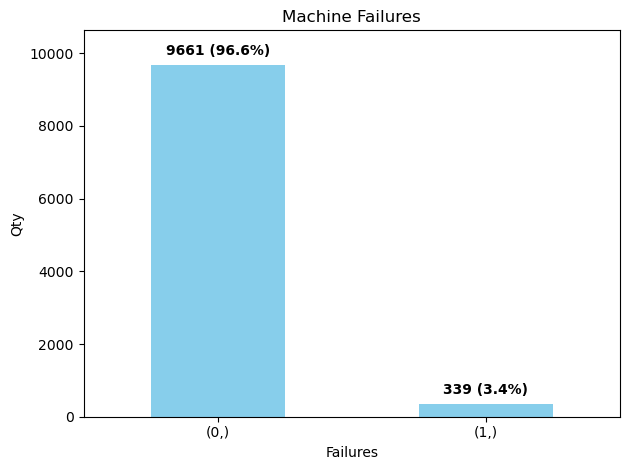

In [143]:
counts = df[['Machine failure']].value_counts().sort_index()
total = counts.sum()

ax = counts.plot(kind='bar', color='skyblue')

# Ajusta o limite do eixo Y (10% acima do maior valor)
ax.set_ylim(0, counts.max() * 1.10)

# Adiciona os rótulos
for i, value in enumerate(counts):
    percent = (value / total) * 100
    ax.text(i, value + (counts.max() * 0.02), f'{value} ({percent:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Machine Failures')
plt.xlabel('Failures')
plt.ylabel('Qty')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Very unbalanced binary classes. It needs to be considered to the modelling.

In [ ]:
def make_safe(name):

    safe = re.sub(r'[^0-9a-zA-Z_]', '_', name)
  
    if re.match(r'^[0-9]', safe):
        safe = 'f_' + safe
    return safe

df.columns = [make_safe(f) for f in df.columns]

df.columns

Index(['UDI', 'Product_ID', 'Type', 'Air_temperature__K_',
       'Process_temperature__K_', 'Rotational_speed__rpm_', 'Torque__Nm_',
       'Tool_wear__min_', 'Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

Data characteristics and distributions

In [147]:
numeric_features = ['Air_temperature__K_',
       'Process_temperature__K_', 'Rotational_speed__rpm_', 'Torque__Nm_',
       'Tool_wear__min_']

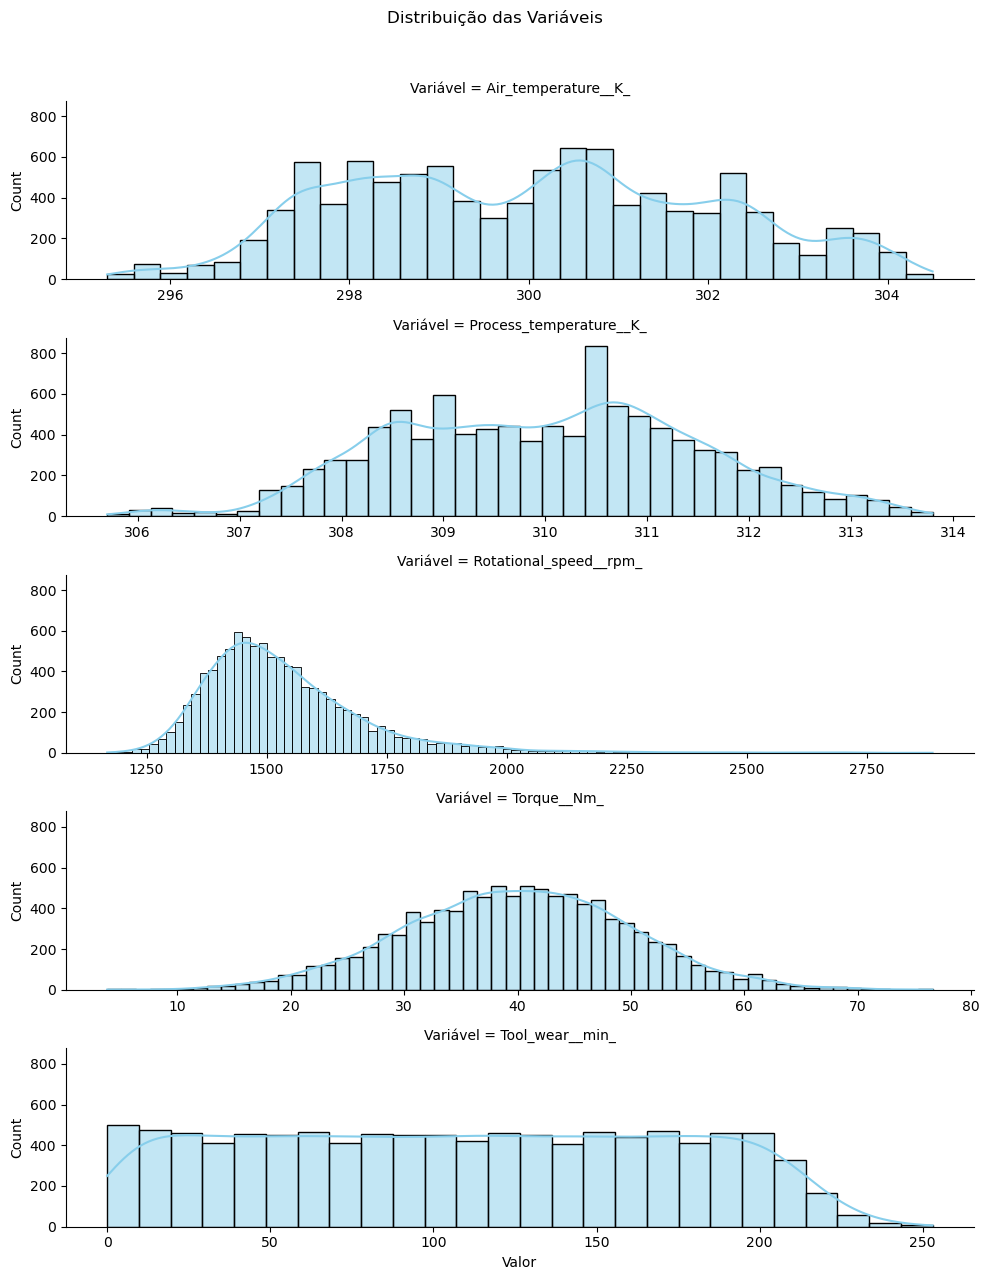

In [167]:
df_long = df[numeric_features].melt(var_name='Variável', value_name='Valor')
g = sns.FacetGrid(df_long, row='Variável', height=2.5, aspect=4, sharex=False)
g.map(sns.histplot, 'Valor', kde=True, color='skyblue')
plt.suptitle('Distribuição das Variáveis', y=1.02)
plt.tight_layout()
plt.show()

Nothing abnormal observed with the data 

### 2. Clusterização com Kmeans

In [ ]:
X = df[numeric_features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

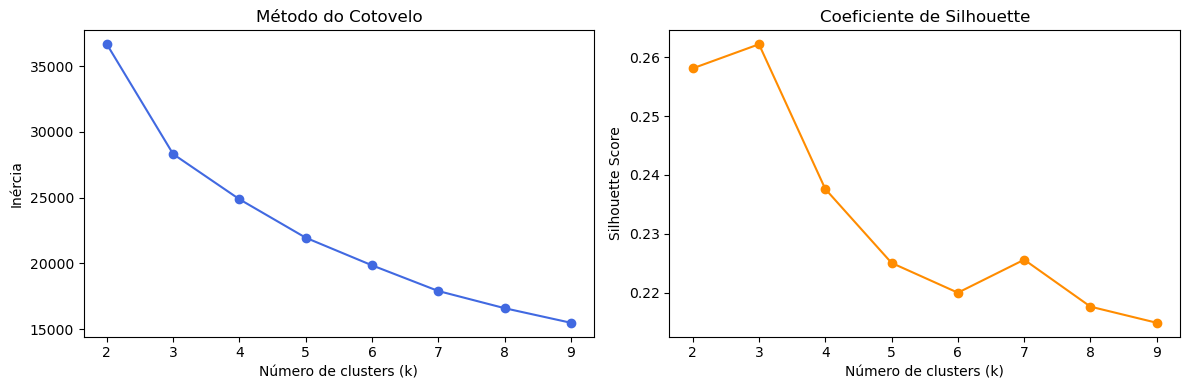

In [ ]:
inertia = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(K, inertia, 'o-', color='royalblue')
ax[0].set_title('Método do Cotovelo')
ax[0].set_xlabel('Número de clusters (k)')
ax[0].set_ylabel('Inércia')

ax[1].plot(K, silhouette, 'o-', color='darkorange')
ax[1].set_title('Coeficiente de Silhouette')
ax[1].set_xlabel('Número de clusters (k)')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


Selected (4) as the total of clusters

In [151]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [153]:
cluster_summary = df.groupby('Cluster').agg({
 'Air_temperature__K_': 'mean',
 'Process_temperature__K_': 'mean',
 'Rotational_speed__rpm_':'mean',
 'Torque__Nm_':'mean',
 'Tool_wear__min_':'mean'
})

cluster_summary
    

,Air_temperature__K_,Process_temperature__K_,Rotational_speed__rpm_,Torque__Nm_,Tool_wear__min_
Cluster,,,,,
0,298.076464,308.600679,1475.667327,43.183564,104.291938
1,301.383515,311.012081,1490.347735,42.070512,169.755872
2,301.539569,311.115160,1473.150338,43.550042,53.337838
3,299.944542,309.970053,1827.126678,25.564857,104.983071


In [ ]:
cluster_counts = df['Cluster'].value_counts().sort_index()

failures = df[df['Machine_failure'] == 1]['Cluster'].value_counts().sort_index()

cluster_summary['Total'] = cluster_counts
cluster_summary['Failures'] = failures
cluster_summary['Failure %'] = (cluster_summary['Failures'] / cluster_summary['Total']) * 100

cluster_summary = cluster_summary.fillna(0)

cluster_summary = cluster_summary.round(2)

cluster_summary

,Air_temperature__K_,Process_temperature__K_,Rotational_speed__rpm_,Torque__Nm_,Tool_wear__min_,Total,Failures,Failure %
Cluster,,,,,,,,
0,298.08,308.60,1475.67,43.18,104.29,3535,72,2.04
1,301.38,311.01,1490.35,42.07,169.76,2384,136,5.70
2,301.54,311.12,1473.15,43.55,53.34,2368,90,3.80
3,299.94,309.97,1827.13,25.56,104.98,1713,41,2.39


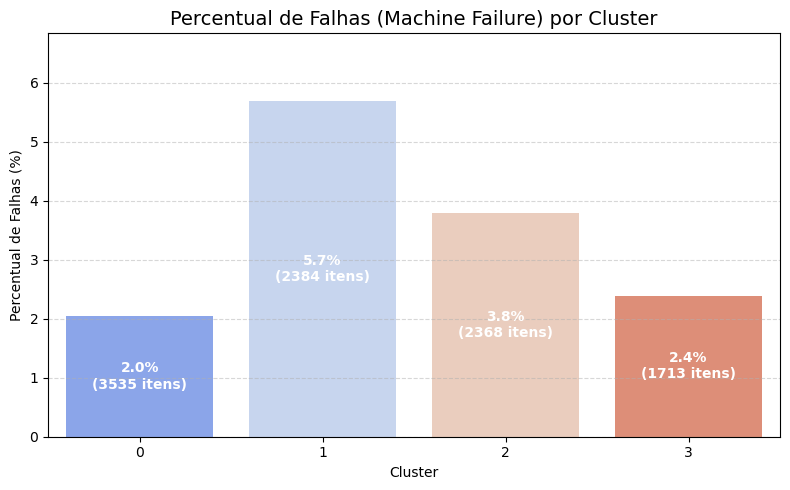

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x=cluster_summary.index,
    y='Failure %',
    data=cluster_summary,
    palette='coolwarm'
)

for i, (total, pct) in enumerate(zip(cluster_summary['Total'], cluster_summary['Failure %'])):
    plt.text(i, pct / 2, f"{pct:.1f}%\n({int(total)} itens)", 
             ha='center', va='center', color='white', fontsize=10, weight='bold')

plt.title('Percentual de Falhas (Machine Failure) por Cluster', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Percentual de Falhas (%)')
plt.ylim(0, cluster_summary['Failure %'].max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 3. Modelling with lightgbm

In [ ]:
X = df[numeric_features]
y = df['Machine_failure']

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pos = sum(y_train == 1)
neg = sum(y_train == 0)
scale_pos_weight = neg / (pos + 1e-9)  

In [159]:
clf = LGBMClassifier(
    objective='binary',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)

In [160]:
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 278, number of negative: 7722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034750 -> initscore=-3.324208
[LightGBM] [Info] Start training from score -3.324208


LGBMClassifier(learning_rate=0.05, n_estimators=1000, n_jobs=-1,
               objective='binary', random_state=42,
               scale_pos_weight=27.77697841716627)

In [161]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba)

print("=== Métricas no conjunto de teste ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred, zero_division=0))

=== Métricas no conjunto de teste ===
Accuracy:  0.9850
Precision: 0.8039
Recall:    0.6721
F1-score:  0.7321
ROC AUC:   0.9741

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1939
           1       0.80      0.67      0.73        61

    accuracy                           0.98      2000
   macro avg       0.90      0.83      0.86      2000
weighted avg       0.98      0.98      0.98      2000



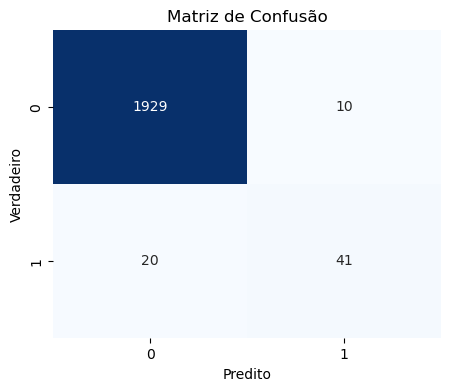

In [162]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

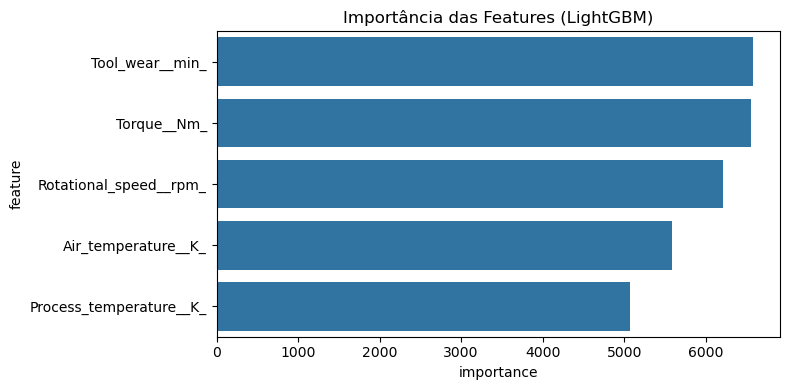

In [163]:
feat_names = numeric_features
importances = clf.feature_importances_
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(data=imp_df, x='importance', y='feature')
plt.title('Importância das Features (LightGBM)')
plt.tight_layout()
plt.show()

In [164]:
df['Predicted Failure Probability'] = clf.predict_proba(X)[:, 1]


In [165]:
cluster_summary['Failure Probability (%)'] = (
    df.groupby('Cluster')['Predicted Failure Probability']
    .mean()
    .mul(100)        # converte para percentual
    .round(2)        # arredonda para 2 casas decimais
)

In [166]:
cluster_summary

,Air_temperature__K_,Process_temperature__K_,Rotational_speed__rpm_,Torque__Nm_,Tool_wear__min_,Total,Failures,Failure %,Failure Probability (%)
Cluster,,,,,,,,,
0,298.08,308.60,1475.67,43.18,104.29,3535,72,2.04,1.91
1,301.38,311.01,1490.35,42.07,169.76,2384,136,5.70,5.57
2,301.54,311.12,1473.15,43.55,53.34,2368,90,3.80,3.78
3,299.94,309.97,1827.13,25.56,104.98,1713,41,2.39,2.37
